In [1]:
# Import packages:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import math
import random

np.random.seed(0)

In [121]:
# QUESTION 1.a): Functions

# Log Marginal Likelihood Using Laplace Estimation
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)),sigma (int), eta (int), epochs (int)
# OUTPUT: Return log marginal likelihood (float), weights (1xD np.array), Hessian (DxD np.array)
def LaplaceEst(x_train, x_valid, x_test, y_train, y_valid, y_test, sigma, eta, epochs):
    # Combine testing and validation values
    xtrain = np.vstack((x_train, x_valid))
    xtrain_bar = np.insert(xtrain, 0, 1, axis = 1) 
    ytrain = np.vstack((y_train[:,(1,)], y_valid[:,(1,)])) 
    ytest = y_test[:,(1,)]
    
    # Find MAP weights 
    w = MAPestimateGD(xtrain_bar, ytrain, sigma, eta, epochs)
    
    print(w)
    
    # Predict on training data
    y_pred = np.dot(xtrain_bar, w)
    
    # Find H
    H = 0
    
    for i in range(xtrain_bar.shape[0]):
        f_hat = (1 / (1 + math.exp(-y_pred[i])))
        H += f_hat*(f_hat-1)*np.outer(xtrain_bar[i],xtrain_bar[i].T)
    
    H += (-1/sigma)*np.identity(H.shape[0])
    
    # Find Laplace estimation
    term1 = log_likelihood(ytrain, y_pred)
    term2 = (-(w.shape[0])/2)*np.log(2*np.pi) - ((w.shape[0])/2)*np.log(sigma) - np.sum(np.square(w)/(2*sigma))
    term3 = (-w.shape[0]/2)*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(-1*H))
    
    m_l = (term1 + term2 - term3)[0]
    
    print(f"Log Marginal Likelihood at Variance of {sigma}: {m_l}")
    
    return m_l, w, H

# Full-batch GD MAP Function
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), eta (int), epochs (int)
# OUTPUT: Return True if successful, False else
def MAPestimateGD(x_comb_1, y_comb, sigma, eta, epochs):
    # Get loss values over epochs
    losses = np.zeros(epochs)
    
    # Initialize weights to zero
    w = np.zeros((x_comb_1.shape[1], 1))
    
    # Train over all epochs
    for epoch in range(epochs):
        
        # Calculate summand
        summand = np.zeros((x_comb_1.shape[1], 1))
        for i in range(x_comb_1.shape[0]):
            summand += np.expand_dims(((y_comb[i] - (1 / (1 + math.exp(-(np.dot(np.transpose(w), x_comb_1[i]))))))*np.transpose(x_comb_1[i])), axis=1)

        # Update w
        w = w - eta*((1/sigma)*w - summand)
        
        # Get loss
        loss = loss_likelihood(x_comb_1, y_comb, w)
        losses[epoch] = loss
        
        # print("GD Descent Training | Epoch: {} | Loss: {}".format(epoch, loss))
    
    return w

# MAP Loss Log-Likelihood Function (should be minimzed)
# INPUT: (NxD np.arrays (X), Nx1 np.arrays (Y), Dx1 np.arrays (W))
# OUTPUT: Negative log-likelihood (float)
def loss_likelihood(x, y, w):
    summand = 0
    
    for i in range(x.shape[0]):
        f_hat = (1 / (1 + math.exp(-(np.dot(np.transpose(w), x[i])))))
        summand += y[i]*np.log(f_hat) + (1-y[i])*np.log(1-f_hat)
    
    return 0.5*np.dot(np.transpose(w), w) - summand

# Log-Likelihood Function
# INPUT: (NxD np.arrays (X), Nx1 np.arrays (Y), Dx1 np.arrays (W))
# OUTPUT: Negative log-likelihood (float)
def log_likelihood(y_real,y_pred):
    
    summand = 0
    
    for i in range(y_real.shape[0]):
        f_hat = (1 / (1 + math.exp(-(y_pred[i]))))
        summand += y_real[i]*np.log(f_hat) + (1-y_real[i])*np.log(1-f_hat)
    
    return summand

In [174]:
# QUESTION 1.a): Main
from data_utils import load_dataset

# 1. Uncomment the dataset you'd like to work with.

print("Working with 'iris'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

# 2. Calculate the marginal likelihoods with all variances in {0.5, 1, 2}

LaplaceEst(x_train, x_valid, x_test, y_train, y_valid, y_test, 0.5, 0.001, 3000)
LaplaceEst(x_train, x_valid, x_test, y_train, y_valid, y_test, 1, 0.001, 3000)
LaplaceEst(x_train, x_valid, x_test, y_train, y_valid, y_test, 2, 0.001, 3000)

Working with 'iris'...
[[-0.82007688]
 [ 0.265592  ]
 [-1.1489532 ]
 [ 0.44044381]
 [-0.61748248]]
Log Marginal Likelihood at Variance of 0.5: -74.82352138474496
[[-0.87797769]
 [ 0.29533252]
 [-1.2358242 ]
 [ 0.67097836]
 [-0.88928511]]
Log Marginal Likelihood at Variance of 1: -74.50608407866096
[[-0.91547847]
 [ 0.2853878 ]
 [-1.27626887]
 [ 0.94181492]
 [-1.15730636]]
Log Marginal Likelihood at Variance of 2: -74.81709336943824


(-74.81709336943824, array([[-0.91547847],
        [ 0.2853878 ],
        [-1.27626887],
        [ 0.94181492],
        [-1.15730636]]), array([[-23.39284813,  -2.35044971,   6.72579557,  -4.46485968,
          -3.71738769],
        [ -2.35044971, -21.62214427,   0.92215297, -17.22370025,
         -15.79859699],
        [  6.72579557,   0.92215297, -15.58171063,   5.72638807,
           4.93334637],
        [ -4.46485968, -17.22370025,   5.72638807, -19.21301631,
         -17.90319492],
        [ -3.71738769, -15.79859699,   4.93334637, -17.90319492,
         -19.22515864]]))

In [172]:
# QUESTION 1.b): Functions

import scipy
np.random.seed(1)

# Importance Sampling Function
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)),sigma (int), eta (int), epochs (int)
# OUTPUT: Return test accuracy (float)
def ImportanceSampling(x_train, x_valid, x_test, y_train, y_valid, y_test, sigma, eta, epochs):
    # Combine testing and validation values
    xtrain = np.vstack((x_train, x_valid))
    xtrain_bar = np.insert(xtrain, 0, 1, axis = 1) 
    ytrain = np.vstack((y_train[:,(1,)], y_valid[:,(1,)])) 
    xtest_bar = np.insert(x_test, 0, 1, axis = 1) 
    ytest = y_test[:,(1,)]
    
    # Get the weights from the marginal likelihood function
    m_l, w, H = LaplaceEst(x_train, x_valid, x_test, y_train, y_valid, y_test, 1, 0.001, 3000)
    
    # Get proposal distribution and samples:
    prop = scipy.stats.multivariate_normal(np.squeeze(w), -np.linalg.inv(H))
    samples = prop.rvs(size=1000)
    
    # Initialize predictions
    y_pred = np.zeros_like(ytest)
    post = []
    
    for i in range(x_test.shape[0]):
        pred = 0
        d = 0
        
        # Calculate the denominator of the equation
        for j in range(samples.shape[0]):
            w_curr = samples[j]
            y_pred_curr = np.dot(xtrain_bar, w_curr)
            pr_w = np.exp((-(w_curr.shape[0])/2)*np.log(2*np.pi) - ((w_curr.shape[0])/2)*np.log(sigma) - np.sum(np.square(w_curr)/(2*sigma)))
            pr_ygwX = np.exp(log_likelihood(ytrain, y_pred_curr))
            q = prop.pdf(w_curr)
            d += ((pr_w*pr_ygwX)/q)[0]
        
        # Calculate the numerator
        for j in range(samples.shape[0]):
            # Get r(w)
            w_curr = samples[j]
            y_pred_curr = np.dot(xtrain_bar, w_curr)
            pr_w = np.exp((-(w_curr.shape[0])/2)*np.log(2*np.pi) - ((w_curr.shape[0])/2)*np.log(sigma) - np.sum(np.square(w_curr)/(2*sigma)))
            pr_ygwX = np.exp(log_likelihood(ytrain, y_pred_curr))
            q = prop.pdf(w_curr)
                
            r = ((pr_w*pr_ygwX)/q)
            
            y_pred_test = np.dot(xtest_bar[i], w_curr)
            
            # Get Pr(y*|w, x*)
            f_hat = (1 / (1 + math.exp(-y_pred_test)))
            
            pred += (f_hat*r)/d
        
            # Find posterior
            if i == x_test.shape[0]-1:
                post.append(np.exp((-w_curr.shape[0]/2)*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(-1*H)) + 1/2*(w_curr-np.squeeze(w)).T@H@(w_curr-np.squeeze(w))))
    
        if pred >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    test_acc = accuracy(ytest, y_pred)
    
    print(f"The test accuracy is {test_acc}%.")
    
    # Obtain the graphs for the posterior evaluated at the sample
    for i in range(0, len(w)):
        w_curr = []
        for j in range(len(samples)):
            w_curr += [samples[j][i]]
        x = np.arange(min(w_curr), max(w_curr), 0.001)
        probability = scipy.stats.norm.pdf(x, w[i], np.sqrt(-np.linalg.inv(H)[i,i]))
    
        fig, ax1 = plt.subplots()
        ax1.scatter(w_curr, post, 1, 'r', label = 'Posterior')
        ax1.set_xlabel('Weight Values')
        ax1.set_ylabel('Distribution')
        ax1.set_ylim([0, np.max(post) + 0.2])
        ax2 = ax1.twinx()
        ax2.scatter(x, probability, 1, label = 'Proposal')
        plt.title('Proposal and Posterior Distribution')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()
        
    return test_acc


# Accuracy Function
# INPUT: Real Y array, predicted Y array (Nx(# of classes) np.arrays)
# OUTPUT: Accuracy of results (float percentage)
def accuracy(y_real,y_pred):
    count = 0
    for line in range(y_real.shape[0]):
        if y_real[line]==y_pred[line]:
            count+=1
    return (count/(y_real.shape[0]))*100

Working with 'iris'...
[[-0.87797769]
 [ 0.29533252]
 [-1.2358242 ]
 [ 0.67097836]
 [-0.88928511]]
Log Marginal Likelihood at Variance of 1: -74.50608407866096
The test accuracy is 73.33333333333333%.


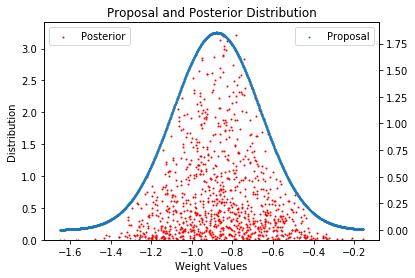

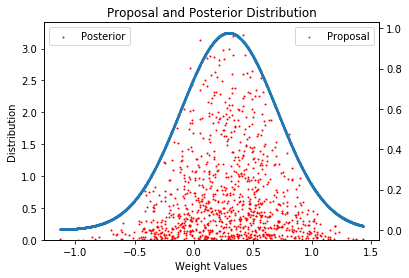

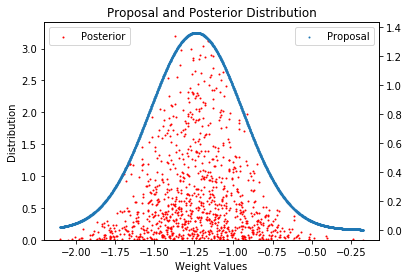

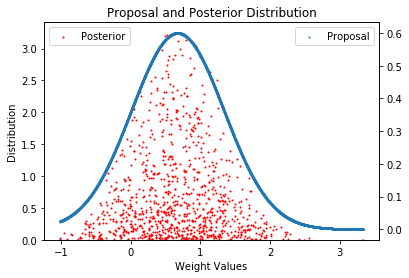

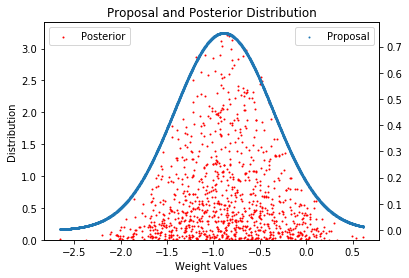

73.33333333333333

In [173]:
# QUESTION 1.b): Main
from data_utils import load_dataset

# 1. Uncomment the dataset you'd like to work with.

print("Working with 'iris'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

# 2. Calculate test accuracy of posterior class predictions
ImportanceSampling(x_train, x_valid, x_test, y_train, y_valid, y_test, 1, 0.001, 3000)

In [225]:
# QUESTION 2: Functions

# Bayesian Linear Model
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), variance (int)
# OUTPUT: True when complete (bool)
def BayesianLinearModel(x_train, x_valid, x_test, y_train, y_valid, y_test, sigma):
    # Combine testing and validation values
    x_train = np.vstack((x_train, x_valid))
    y_train = np.vstack((y_train, y_valid)) 
    
    # Get phi, mu, sigma 
    phi = features(x_train)
    inv_cov = (1/sigma)*(phi.T@phi) + np.linalg.inv(np.identity(phi.shape[1]))
    L = np.linalg.cholesky(inv_cov)
    cov = np.linalg.inv(L).T@np.linalg.inv(L)
    mu = (1/sigma)*(cov@phi.T@y_train)
    
    # Get predictive mu and predictive sigma
    upper = np.zeros((x_test.shape[0]))
    lower = np.zeros_like(upper)
    mu_pred = np.zeros_like(upper)
    
    for i in range(x_test.shape[0]):
        mu_pred[i] = features(x_test[i,0]).T@mu
        std_dev = np.sqrt(features(x_test[i,0]).T@cov@features(x_test[i,0]) + sigma)
        upper[i] = mu_pred[i] + 3*std_dev
        lower[i] = mu_pred[i] - 3*std_dev
        
    # Plot the results
    plt.title("Predictive Posterior Distribution")
    plt.xlabel("Time")
    plt.ylabel("C02 Levels")
    plt.plot(x_test, y_test, color='b', label="Actual Test Data")
    plt.plot(x_test, mu_pred, color ='g', label="Predictive Posterior Mean")
    plt.fill_between(np.squeeze(x_test), lower, upper, color='r', alpha =0.1)
    plt.legend()
    plt.show()
    
    # Plot difference
    plt.clf()
    plt.title("Difference Between Test and Predictive Posterior Mean")
    plt.xlabel("Time")
    plt.ylabel("C02 Levels")
    plt.plot(x_test, mu_pred - np.squeeze(y_test), color='b')
    plt.show()
    
    return True

# Feature function
# INPUT: Training point vector (NxD np.array)
# OUTPUT: Phi (NxM np.array)
def features(x):
    year = 0.057 # equal to one year in input space
    phi = np.hstack([np.power(x, np.arange(11))] + [np.sin(x*2*np.pi*factor/year) for factor in range(1,11)] + [np.cos(x*2*np.pi*factor/year) for factor in range(1,11)] )
    return phi

Working with 'mauna_loa'...


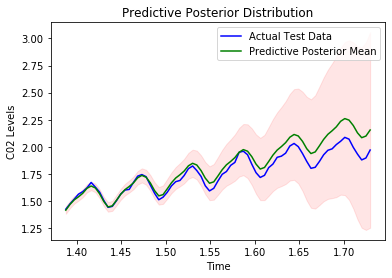

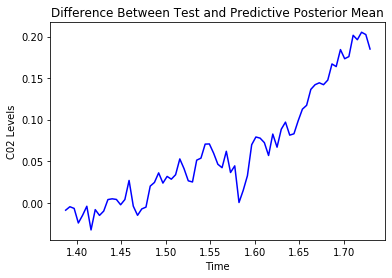

True

In [226]:
# QUESTION 2: Main

from data_utils import load_dataset

# 1. Uncomment the dataset you'd like to work with.
print("Working with 'mauna_loa'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')

# 2. Plot the results of the Bayesian linear model estimation
BayesianLinearModel(x_train, x_valid, x_test, y_train, y_valid, y_test, 10**(-4))